## Urban Expansion in Nairobi, Kenya 
Yujin Song, Lu Yii Wong

## 1. Problem Statement
Urban sprawl in Nairobi has led to inefficient infrastructure, increased transportation costs, and environmental degradation. Traditional monitoring methods, such as census and survey data, are often outdated and lack spatial detail. A remote sensing-based approach can provide timely, scalable insights into urban expansion. 

Nairobi is East Africa’s fastest-growing city, with a population that  surged from 290,000 in 1960 to over 5 million in 2023. This rapid growth has fueled unregulated expansion, particularly in informal settlements like Kibera and Korogocho, exacerbating land tenure issues and inadequate public services, such as water and electricity access. Effective planning requires a data-driven approach to monitoring and managing urban growth.

## 2. Target User

Our project is designed for Nairobi’s stakeholders and planning agencies responsible for infrastructure, land use, and public services. These stakeholders require spatially detailed, up-to-date insights to guide decision-making in informal settlement management, infrastructure investment, and environmental monitoring.

## 3. Methodology
For this project, we acquire satellite images at 5-year intervals to track changes in land use and land cover over time. We started our study in 1984, using Landsat 5 images to give us a good understanding of historical land use change during a period of rapid population growth in Nairobi.

We selected three key years for manual labeling based on Landsat sensor generations and trained machine learning models accordingly to classify land use across all years from 1984 to 2023.


## 4. Data Sources

We used Landsat satellite imagery obtained from Google Earth Engine to monitor land use change in Nairobi from 1984 to 2023. Images were selected at approximately 5-year intervals, filtered for cloud cover, and clipped to the Nairobi region boundary.

| Year | Landsat Sensor | Dataset ID                      |
|------|----------------|----------------------------------|
| 1984 | Landsat 5       | LANDSAT/LT05/C02/T1_L2          |
| 1994 | Landsat 5       | LANDSAT/LT05/C02/T1_L2          |
| 1999 | Landsat 7       | LANDSAT/LE07/C02/T1_L2          |
| 2004 | Landsat 7       | LANDSAT/LE07/C02/T1_L2          |
| 2009 | Landsat 7       | LANDSAT/LE07/C02/T1_L2          |
| 2014 | Landsat 8       | LANDSAT/LC08/C02/T1_L2          |
| 2019 | Landsat 8       | LANDSAT/LC08/C02/T1_L2          |
| 2023 | Landsat 8       | LANDSAT/LC08/C02/T1_L2          |

**Note on Data Availability**  
We were unable to obtain usable imagery for 1989 due to persistent cloud cover and data quality limitations in the Landsat 5 archive. For 1994 and 1999, we relaxed the cloud cover threshold (up to 30%) and expanded the date range to ensure that valid composites could be generated. These fallback adjustments allowed us to preserve temporal consistency while accounting for gaps in imagery availability.

### 4.1 Pulling Landsat Data

In [2]:
import ee
ee.Initialize()

# Define Nairobi bounding box
nairobi = ee.Geometry.Rectangle([36.6, -1.5, 37.1, -1.1])

# Function to get Landsat image composite by year and sensor
def get_landsat_composite_all_bands(year):
    start = f'{year}-01-01'
    end = f'{year}-12-31'
    
    if year >= 2014:
        collection_id = 'LANDSAT/LC08/C02/T1_L2'
    elif year >= 2004:
        collection_id = 'LANDSAT/LE07/C02/T1_L2'
    else:
        collection_id = 'LANDSAT/LT05/C02/T1_L2'

    collection = ee.ImageCollection(collection_id) \
        .filterBounds(nairobi) \
        .filterDate(start, end) \
        .filter(ee.Filter.lt('CLOUD_COVER', 10))
    
    # Apply scaling to SR bands only, leave QA/thermal untouched
    def scale_sr(img):
        sr_bands = img.select(img.bandNames().filter(ee.Filter.stringContains('item', 'SR_')))
        scaled = sr_bands.multiply(0.0000275).add(-0.2)
        others = img.select(img.bandNames().removeAll(sr_bands.bandNames()))
        return scaled.addBands(others).copyProperties(img, img.propertyNames())
    
    processed = collection.map(scale_sr)
    return processed.median().clip(nairobi)

# List of years to export
years = [1984, 1989, 1994, 1999, 2004, 2009, 2014, 2019, 2023]

# Loop and export images
tasks = []
for year in years:
    image = get_landsat_composite_all_bands(year)
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'Nairobi_Landsat_{year}_AllBands',
        folder='earthengine',
        fileNamePrefix=f'nairobi_landsat_{year}_allbands',
        region=nairobi,
        scale=30,
        maxPixels=1e13
    )
    task.start()
    tasks.append((year, task))

# Optional: print task status
for year, task in tasks:
    print(f"Export task for {year}: {task.status()['state']}")


Successfully saved authorization token.
Export task for 1984: READY
Export task for 1989: READY
Export task for 1994: READY
Export task for 1999: READY
Export task for 2004: READY
Export task for 2009: READY
Export task for 2014: READY
Export task for 2019: READY
Export task for 2023: READY


## 5. Labeling Process and Ground Truths

To generate training data, we manually labeled satellite imagery using **ArcGIS Pro**. Labels were assigned at the pixel level by visually interpreting Landsat images, referencing road patterns, building density, and Google Maps overlays.

We created ground truth labels for three key years:
- **1984** (Landsat 5)
- **2009** (Landsat 7)
- **2019** (Landsat 8)

For each year, we labeled approximately 900 training points across three land use categories:
- 0: Vegetation
- 1: Informal settlement
- 2: Formal settlement

To guide labeling and ensure spatial accuracy, we used known settlement areas in Nairobi as ground truth anchors.

**Informal Settlements Used for Reference:**
| Settlement | Approximate Establishment | Key Growth Period |
|------------|----------------------------|-------------------|
| Kibera     | 1904s                      | 1960s–1990s        |
| Mathare    | 1920s–1930s                 | 1950s–1970s        |
| Korogocho  | 1970s                      | 1980s–1990s        |
| Mukuru Kwa Njenga | 1980s                | 1990s–2000s        |

**Formal Settlements Used for Reference:**
| Settlement | Approximate Establishment | Key Growth Period |
|------------|----------------------------|-------------------|
| Starehe    | 1900s                      | 1960s–1990s        |
| Westlands  | 1920s–1930s                 | 1950s–1970s        |
| Lang’ata   | 1970s                      | 1980s–1990s        |
| Kasarani   | 1980s                      | 1990s–2000s        |

While we took care to align our labels with visible features- block patterns, access roads, and consistent building density, we acknowledge the challenges of interpreting informal vs. formal areas purely through satellite imagery.

## 6. Training and Classification

In [3]:
# Load Libraries 
import geopandas as gpd
import pandas as pd

In [4]:
# Load shapefiles
formal_gdf = gpd.read_file("landuse_class/formal.shp")
informal_gdf = gpd.read_file("landuse_class/informal.shp")
vegetation_gdf = gpd.read_file("landuse_class/vegetation.shp")

# Drop 'Id' columns in formal and vegetation
formal_gdf = formal_gdf.drop(columns=["Id"], errors='ignore')
vegetation_gdf = vegetation_gdf.drop(columns=["Id"], errors='ignore')

# Combine all into a single GeoDataFrame
combined_gdf = pd.concat([formal_gdf, informal_gdf, vegetation_gdf], ignore_index=True)

# Check the result (total of 900 points per lu class)
print(combined_gdf.head())
print(combined_gdf["landuse"].value_counts())

  landuse  database                   geometry
0  formal      1984  POINT (36.81875 -1.28296)
1  formal      1984  POINT (36.82147 -1.28555)
2  formal      1984  POINT (36.82169 -1.28429)
3  formal      1984  POINT (36.82322 -1.28458)
4  formal      1984  POINT (36.81933 -1.28491)
landuse
formal        900
informal      900
vegetation    900
Name: count, dtype: int64


In [5]:
# Check Projection
print(combined_gdf.crs)

EPSG:4326


### 6.1 Load Landsat TIF files

We downloaded preprocessed multi-band Landsat `.tif` images for 1984, 2009, and 2019 using public Dropbox links. These images were exported from Google Earth Engine and include reflectance bands clipped to the Nairobi boundary. The script below automatically downloads the files and saves them to a local directory.

Each file corresponds to one labeled year and is used to train a classification model for its associated Landsat sensor.

In [6]:
import requests
import os 

In [7]:
# Create new output folder 
output_dir = "landsat_images"
os.makedirs(output_dir, exist_ok=True)

# Download multiple files
landsat_files = {
    "1984": "https://www.dropbox.com/scl/fi/nk6xavounp62ua13knj8z/nairobi_landsat_1984_allbands.tif?rlkey=1hy39oiei4fwcsahydg007n6s&st=smighyej&dl=1",
    "2009": "https://www.dropbox.com/scl/fi/flagfp77yvcyxt0b7plyj/nairobi_landsat_2009_allbands.tif?rlkey=etoqn6whwlkkz08cis68oyp6q&st=gpi4nlk5&dl=1",
    "2019": "https://www.dropbox.com/scl/fi/l09necnzqgyigbd13iddp/nairobi_landsat_2019_allbands.tif?rlkey=0gec6urstoqomk6141f2ag5re&st=4h1715d2&dl=1"
}

for year, url in landsat_files.items():
    output_path = os.path.join(output_dir, f"landsat_{year}.tif")
    r = requests.get(url)
    with open(output_path, 'wb') as f:
        f.write(r.content)
    print(f"Downloaded landsat_{year}.tif to {output_path}")


Downloaded landsat_1984.tif to landsat_images/landsat_1984.tif
Downloaded landsat_2009.tif to landsat_images/landsat_2009.tif
Downloaded landsat_2019.tif to landsat_images/landsat_2019.tif


### 6.2 Preprocessing

Before training the classification model, we prepare the Landsat imagery by loading each `.tif` file using the `rasterio` library. This includes checking the coordinate reference system (CRS) to ensure spatial consistency across all images and shapefiles.

The Landsat files are multi-band raster images containing surface reflectance values for each band. These bands will be used as features for model training.
The code below imports required libraries, loads the 1984 image, and prints the CRS to confirm the image is projected correctly. All imagery in this project uses the same CRS to allow spatial alignment with training labels and output classifications.

In [8]:
# Load Libraries
import rasterio
import rasterio.mask
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from shapely.geometry import box

In [9]:
# Check Projection
landsat_1984 = "landsat_images/landsat_1984.tif"

# Open the image and print its CRS
with rasterio.open(landsat_1984) as src:
    print("CRS:", src.crs)

CRS: EPSG:4326


### 6.3 Split Training Data by Year

We split the labeled training data by year (1984, 2009, 2019), corresponding to each Landsat sensor generation. The `classify_year()` function takes in the raster image and training labels, trains a Random Forest model, classifies the entire image, and exports the results as a `.tif` file.

This step ensures that each model is trained on consistent sensor data before applying it to other years within the same Landsat group.

In [10]:
# Create Geodataframes with the labeled data by year
gdf_1984 = combined_gdf[combined_gdf['database'] == 1984]
gdf_2009 = combined_gdf[combined_gdf['database'] == 2009]
gdf_2019 = combined_gdf[combined_gdf['database'] == 2019]

In [11]:
# Classifier function

def classify_year(year, gdf, tif_path, out_path):
    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    # Open raster
    with rasterio.open(tif_path) as src:
        image = src.read()  # (bands, rows, cols)
        transform = src.transform
        raster_crs = src.crs
        raster_bounds = src.bounds
        meta = src.meta.copy()
        _, n_rows, n_cols = image.shape

    # Reproject training points to match raster
    if gdf.crs != raster_crs:
        gdf = gdf.to_crs(raster_crs)

    # Filter training points to those within raster extent
    raster_geom = box(*raster_bounds)
    gdf = gdf[gdf.geometry.within(raster_geom)]
    print(f"[{year}] Points after spatial filter: {len(gdf)}")

    if len(gdf) == 0:
        raise ValueError(f"No valid training points within raster bounds for year {year}.")

    # Extract coordinates and labels
    coords = [(geom.x, geom.y) for geom in gdf.geometry]
    labels = gdf['landuse'].astype('category').cat.codes.values

    # Convert coordinates to row/col pixel positions
    rows_cols = [~transform * (x, y) for x, y in coords]
    rows, cols = zip(*rows_cols)
    rows = np.array(rows)
    cols = np.array(cols)

    # Filter NaNs
    valid = (~np.isnan(rows)) & (~np.isnan(cols))
    rows = rows[valid].astype(int)
    cols = cols[valid].astype(int)
    labels = labels[valid]

    # Filter to points within raster dimensions
    in_bounds = (rows >= 0) & (rows < n_rows) & (cols >= 0) & (cols < n_cols)
    rows = rows[in_bounds]
    cols = cols[in_bounds]
    labels = labels[in_bounds]

    print(f"[{year}] Training samples used: {len(labels)}")

    # Extract pixel values for training
    samples = image[:, rows, cols].T  # shape: (samples, bands)

    # Train Random Forest model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(samples, labels)

    # Classify entire raster
    reshaped_img = image.reshape(image.shape[0], -1).T
    predictions = clf.predict(reshaped_img)
    classified = predictions.reshape((n_rows, n_cols))

    # Save output raster
    meta.update({"count": 1, "dtype": 'int16'})
    with rasterio.open(out_path, "w", **meta) as dest:
        dest.write(classified.astype('int16'), 1)

    print(f"[{year}] Classification complete. Saved to {out_path}")

    return clf, samples, labels


In [12]:
clf_1984, samples_1984, labels_1984 = classify_year(
    year='1984',
    gdf=gdf_1984,
    tif_path='landsat_images/landsat_1984.tif',
    out_path='classified_outputs/classified_1984.tif'
)

clf_2009, samples_2009, labels_2009 = classify_year(
    year='2009',
    gdf=gdf_2009,
    tif_path='landsat_images/landsat_2009.tif',
    out_path='classified_outputs/classified_2009.tif'
)

clf_2019, samples_2019, labels_2019 = classify_year(
    year='2019',
    gdf=gdf_2019,
    tif_path='landsat_images/landsat_2019.tif',
    out_path='classified_outputs/classified_2019.tif'
)


[1984] Points after spatial filter: 899
[1984] Training samples used: 899
[1984] Classification complete. Saved to classified_outputs/classified_1984.tif
[2009] Points after spatial filter: 900
[2009] Training samples used: 900
[2009] Classification complete. Saved to classified_outputs/classified_2009.tif
[2019] Points after spatial filter: 900
[2019] Training samples used: 880
[2019] Classification complete. Saved to classified_outputs/classified_2019.tif


**Classifier Output Summary**

The model successfully used nearly all labeled training points after spatial filtering. For 1984 and 2009, most points within the training dataset were retained and used. For 2019, 20 points were excluded due to falling outside the raster extent or invalid pixel positions.

The classification was completed for all three labeled years, and results were saved as `.tif` files in the `classified_outputs` directory. These classified rasters will be used to analyze land use patterns and trends across time.

### 6.4 Train-Test Split
Split the data into training and testing sets to evaluate how well the classifier might generalize on unseen data.

To evaluate the performance of our classifiers, we validate each model on its corresponding training data (1984, 2009, and 2019).  
While this isn't a true test set evaluation, it helps us assess how well the Random Forest model fits the training samples.

We report classification metrics (precision, recall, F1-score) and visualize confusion matrices to identify class-level misclassifications.

The model achieved near-perfect classification accuracy on the training data across all labeled years.  
While this level of performance is *insanely high* , it's important to note that the results are based on in-sample predictions and may not reflect generalization to new areas or years.

We summarize accuracy scores by year below:


=== 1984 Classification Report ===
              precision    recall  f1-score   support

      Formal       1.00      1.00      1.00        60
    Informal       0.98      1.00      0.99        60
  Vegetation       1.00      0.98      0.99        60

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



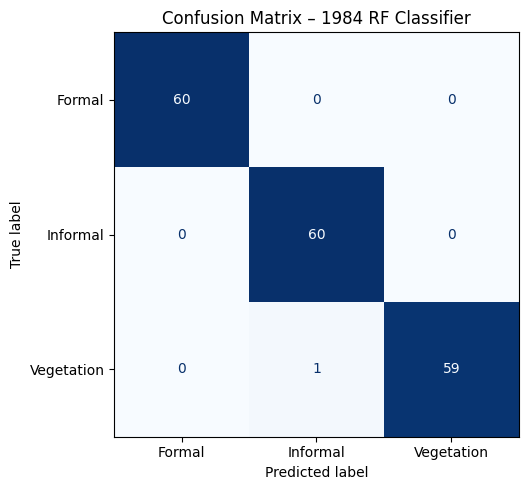


=== 2009 Classification Report ===
              precision    recall  f1-score   support

      Formal       0.75      0.73      0.74        60
    Informal       0.81      0.73      0.77        60
  Vegetation       0.84      0.93      0.88        60

    accuracy                           0.80       180
   macro avg       0.80      0.80      0.80       180
weighted avg       0.80      0.80      0.80       180



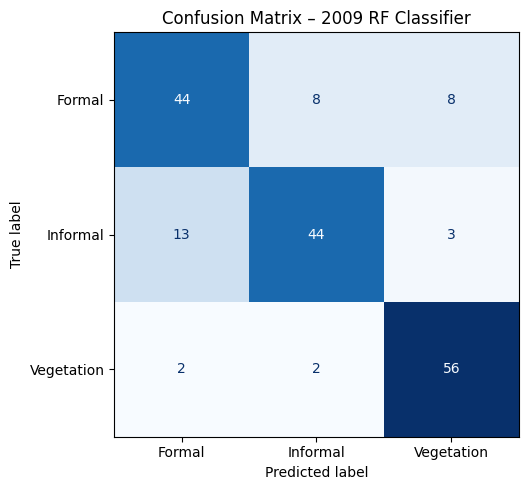


=== 2019 Classification Report ===
              precision    recall  f1-score   support

      Formal       0.98      0.93      0.96        60
    Informal       0.91      0.98      0.94        60
  Vegetation       0.94      0.91      0.93        56

    accuracy                           0.94       176
   macro avg       0.94      0.94      0.94       176
weighted avg       0.94      0.94      0.94       176



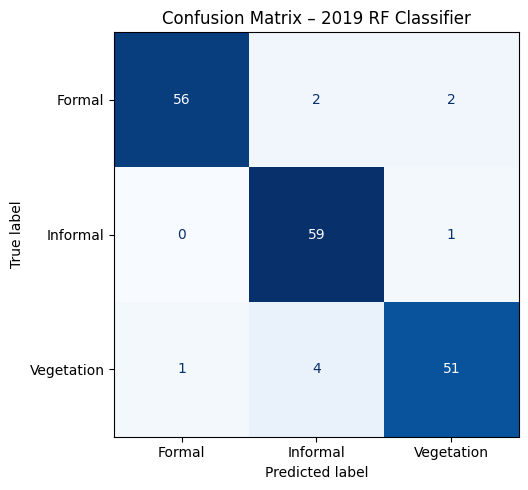

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Store data
training_data = {
    "1984": (samples_1984, labels_1984),
    "2009": (samples_2009, labels_2009),
    "2019": (samples_2019, labels_2019)
}

class_names = ['Formal', 'Informal', 'Vegetation']

for year, (samples, labels) in training_data.items():
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        samples, labels, test_size=0.2, stratify=labels, random_state=42
    )

    # Train model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Print classification report
    print(f"\n=== {year} Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f"Confusion Matrix – {year} RF Classifier")
    plt.tight_layout()
    plt.show()


### 6.5 Urban Sprawl Analysis
To analyze land use change over time, we calculate the total area (in square kilometers) for each classified land use type in 1984, 2009, and 2019. The area is computed by multiplying the number of pixels per class by the square of the pixel size (30m x 30m).

We then visualize the change in formal settlements, informal settlements, and vegetation using a line chart to highlight urban expansion trends across the three decades.

In [16]:
# Function calculating area of each land use class (by converting number of pixels)

def calculate_area_by_class(classified_tif, pixel_size=30, year=None):
    with rasterio.open(classified_tif) as src:
        classified = src.read(1)
        transform = src.transform

    classes, counts = np.unique(classified, return_counts=True)

    area_sqkm = counts * (pixel_size**2) / 1e6  # convert m² to km²
    result = pd.DataFrame({
        'class_code': classes,
        'area_km2': area_sqkm
    })

    if year:
        result['year'] = year

    return result

# Run for each year
df_1984 = calculate_area_by_class('classified_outputs/classified_1984.tif', year=1984)
df_2009 = calculate_area_by_class('classified_outputs/classified_2009.tif', year=2009)
df_2019 = calculate_area_by_class('classified_outputs/classified_2019.tif', year=2019)

# Combine
area_summary = pd.concat([df_1984, df_2009, df_2019], ignore_index=True)
# Add in Class Names
class_names = {0: "Formal", 1: "Informal", 2: "Vegetation"}
area_summary['landuse'] = area_summary['class_code'].map(class_names)

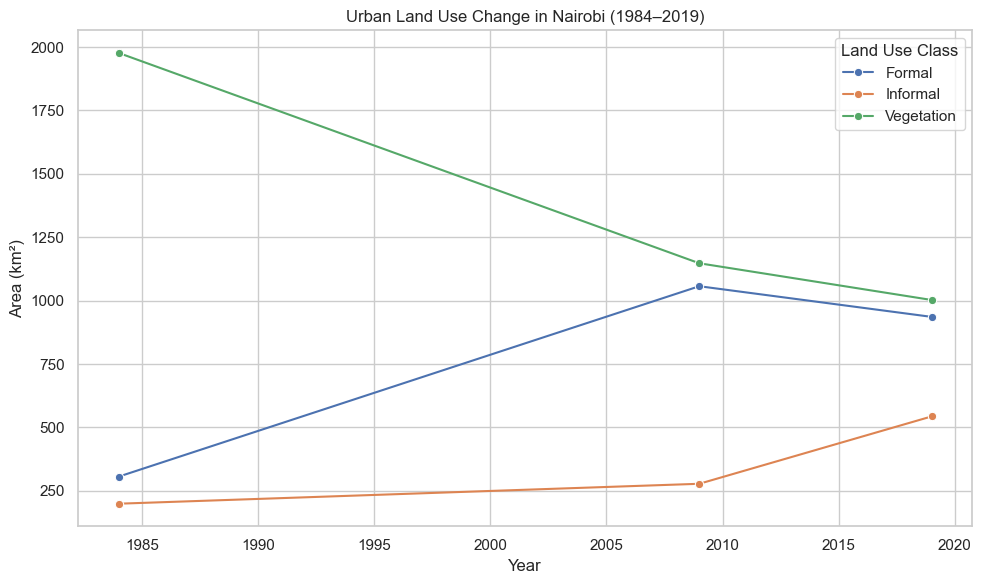

In [17]:
# Map Urban Sprawl Trends
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=area_summary, x='year', y='area_km2', hue='landuse', marker='o')
plt.title('Urban Land Use Change in Nairobi (1984–2019)')
plt.ylabel('Area (km²)')
plt.xlabel('Year')
plt.legend(title='Land Use Class')
plt.tight_layout()
plt.show()


In [18]:
# Comparing Informal and Formal Growth
pivoted = area_summary.pivot(index='year', columns='landuse', values='area_km2').reset_index()
pivoted['informal_growth'] = pivoted['Informal'].pct_change() * 100
pivoted['formal_growth'] = pivoted['Formal'].pct_change() * 100

print(pivoted[['year', 'Informal', 'Formal', 'informal_growth', 'formal_growth']])


landuse  year  Informal    Formal  informal_growth  formal_growth
0        1984   199.135   305.699              NaN            NaN
1        2009   277.719  1056.800           39.463        245.700
2        2019   543.303   935.971           95.630        -11.433


**Interpretation of Urban Sprawl Trends**

Between 1984 and 2009, both formal and informal settlement areas in Nairobi expanded significantly. Formal areas grew by approximately 246 km², while informal areas increased by 38 km².
However, from 2009 to 2019, the growth pattern shifted. Informal settlements nearly **doubled** (a 98 km² increase), while formal development **declined slightly**, possibly due to land saturation, redevelopment, or misclassification in high-density zones. This trend suggests increasing reliance on informal housing solutions and highlights the urgency for inclusive urban planning to address unregulated growth.


### 6.6 Predicting Land Use for Unlabeled Years

Given that we only trained classifers for three years with labeled data, now, we want to apply those models to predict land use for the remaning years with unlabeled data:
- Landsat 5 Model (1984): 1994
- Landsat 7 model (2009): 1999, 2004
- Landsat 8 OLI model (2019): 2014, 2023

Access Links to Landsat Images:
- 1994: https://www.dropbox.com/scl/fi/yprh8z2e4en0rrbb68so0/nairobi_landsat_1994_fallback_allbands.tif?rlkey=u8up26q0w0kwyecajlzekhisr&st=a4xgaxnh&dl=1
- 1999: https://www.dropbox.com/scl/fi/twnukoz1nkj9x3mpcpea2/nairobi_landsat_1999_fallback_allbands.tif?rlkey=154s8whnxmcjf9og2awwc043x&st=mdi0jf7l&dl=1
- 2004: https://www.dropbox.com/scl/fi/pz3o5syavhb6e9nzsvzyk/nairobi_landsat_2004_allbands.tif?rlkey=j23q1xfr5nlxf15z4s7c7oilo&st=76j9ie3y&dl=1 
- 2014: https://www.dropbox.com/scl/fi/p1j3y9p05akytyzf8cfqs/nairobi_landsat_2014_allbands.tif?rlkey=w5xz2na5iw2k8qs8tpi956jlx&st=ffnh9ura&dl=1 
- 2023: https://www.dropbox.com/scl/fi/a51vdlt7017ho1trgxpzg/nairobi_landsat_2023_allbands.tif?rlkey=z6jg7oh4dwtciwlae0qzlrajk&st=ed651nug&dl=1 


In [32]:
import requests

# Step 1: Download the remaining Landsat images
extra_landsat_files = {
    "1994": "https://www.dropbox.com/scl/fi/yprh8z2e4en0rrbb68so0/nairobi_landsat_1994_fallback_allbands.tif?rlkey=u8up26q0w0kwyecajlzekhisr&st=3gr7t3jm&dl=1",
    "1999": "https://www.dropbox.com/scl/fi/twnukoz1nkj9x3mpcpea2/nairobi_landsat_1999_fallback_allbands.tif?rlkey=154s8whnxmcjf9og2awwc043x&st=9u74skya&dl=1",
    "2004": "https://www.dropbox.com/scl/fi/pz3o5syavhb6e9nzsvzyk/nairobi_landsat_2004_allbands.tif?rlkey=j23q1xfr5nlxf15z4s7c7oilo&st=vsd1hia4&dl=1",
    "2014": "https://www.dropbox.com/scl/fi/p1j3y9p05akytyzf8cfqs/nairobi_landsat_2014_allbands.tif?rlkey=w5xz2na5iw2k8qs8tpi956jlx&st=qjelpfd0&dl=1",
    "2023": "https://www.dropbox.com/scl/fi/a51vdlt7017ho1trgxpzg/nairobi_landsat_2023_allbands.tif?rlkey=z6jg7oh4dwtciwlae0qzlrajk&st=9d40izg4&dl=1"
}
# Download images
for year, url in extra_landsat_files.items():
    out_path = f"landsat_images/landsat_{year}.tif"
    if not os.path.exists(out_path):
        r = requests.get(url)
        with open(out_path, 'wb') as f:
            f.write(r.content)
        print(f"Downloaded landsat_{year}.tif")
    else:
        print(f"Already downloaded: landsat_{year}.tif")



Downloaded landsat_1994.tif
Downloaded landsat_1999.tif
Downloaded landsat_2004.tif
Downloaded landsat_2014.tif
Downloaded landsat_2023.tif


In [33]:
# Step 2: Apply trained models to these years
# Use same classify_year() function but skip retraining

def apply_existing_model(clf, year, tif_path, out_path):
    with rasterio.open(tif_path) as src:
        image = src.read()
        meta = src.meta.copy()
        n_rows, n_cols = image.shape[1], image.shape[2]

    reshaped_img = image.reshape(image.shape[0], -1).T
    predictions = clf.predict(reshaped_img)
    classified = predictions.reshape((n_rows, n_cols))

    meta.update({"count": 1, "dtype": 'int16'})
    with rasterio.open(out_path, "w", **meta) as dest:
        dest.write(classified.astype('int16'), 1)
    print(f"[{year}] Predicted land use saved to {out_path}")

# Predict for each year
apply_existing_model(clf_1984, "1994", "landsat_images/landsat_1994.tif", "classified_outputs/classified_1994.tif")
apply_existing_model(clf_2009, "1999", "landsat_images/landsat_1999.tif", "classified_outputs/classified_1999.tif")
apply_existing_model(clf_2009, "2004", "landsat_images/landsat_2004.tif", "classified_outputs/classified_2004.tif")
apply_existing_model(clf_2019, "2014", "landsat_images/landsat_2014.tif", "classified_outputs/classified_2014.tif")
apply_existing_model(clf_2019, "2023", "landsat_images/landsat_2023.tif", "classified_outputs/classified_2023.tif")

[1994] Predicted land use saved to classified_outputs/classified_1994.tif
[1999] Predicted land use saved to classified_outputs/classified_1999.tif
[2004] Predicted land use saved to classified_outputs/classified_2004.tif
[2014] Predicted land use saved to classified_outputs/classified_2014.tif
[2023] Predicted land use saved to classified_outputs/classified_2023.tif


## 7. Urban Sprawl Trends: Full 1984–2023 Analysis

We now extend our urban land use analysis by including predicted classifications for the intermediate years.  
This allows us to visualize long-term trends in formal development, informal expansion, and vegetation change across 40 years.

Using the same area calculation function, we extract class-wise area (in km²) and generate a complete trend chart.

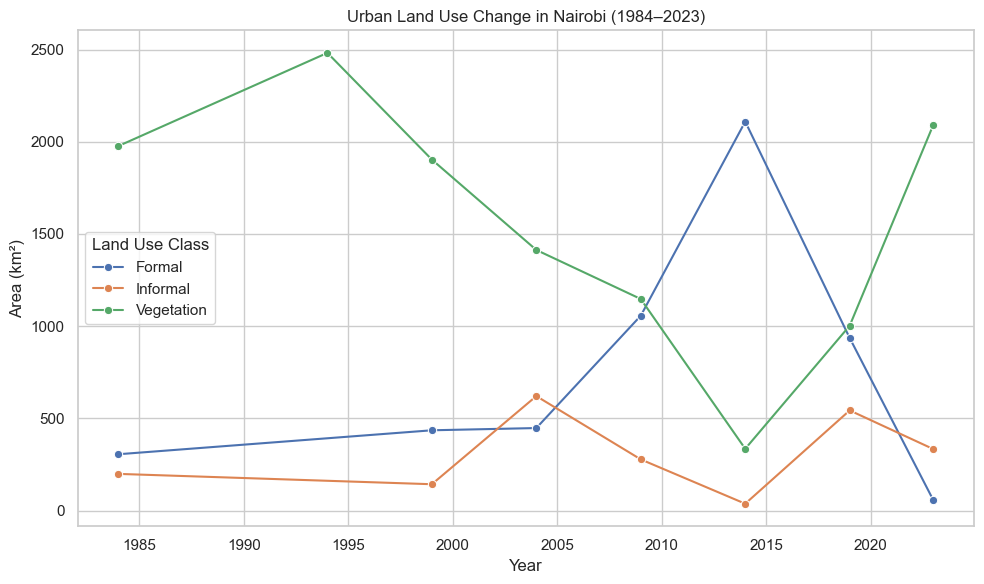

In [34]:
# def calculate_area_by_class
# Calculate area for the new years
df_1994 = calculate_area_by_class('classified_outputs/classified_1994.tif', year=1994)
df_1999 = calculate_area_by_class('classified_outputs/classified_1999.tif', year=1999)
df_2004 = calculate_area_by_class('classified_outputs/classified_2004.tif', year=2004)
df_2014 = calculate_area_by_class('classified_outputs/classified_2014.tif', year=2014)
df_2023 = calculate_area_by_class('classified_outputs/classified_2023.tif', year=2023)

# Combine all years
full_area_summary = pd.concat([
    df_1984, df_1994, df_1999, df_2004, df_2009,
    df_2014, df_2019, df_2023
], ignore_index=True)

# Map class codes to land use names
class_names = {0: "Formal", 1: "Informal", 2: "Vegetation"}
full_area_summary['landuse'] = full_area_summary['class_code'].map(class_names)

# Plot full 1984–2023 trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=full_area_summary, x='year', y='area_km2', hue='landuse', marker='o')
plt.title('Urban Land Use Change in Nairobi (1984–2023)')
plt.ylabel('Area (km²)')
plt.xlabel('Year')
plt.legend(title='Land Use Class')
plt.tight_layout()
plt.show()


### 7.1 Interpreting Land Use Change Trends (1984–2023)

The classified land use results from 1984 to 2023 reveal nonlinear and, at times, unexpected trends in Nairobi’s urban development and vegetation cover.  
While informal settlement growth appears consistent with known patterns of urbanization, both formal settlements and vegetation display sharp fluctuations — suggesting potential misclassification or data issues.

#### Model Behavior and Visual Checks

Between **2009 and 2014**, the classified area of formal settlements rose dramatically, while both informal settlements and vegetation dropped significantly.  
From **2014 to 2023**, this trend reversed: formal area plummeted, vegetation surged, and informal growth leveled out.

To evaluate whether these patterns reflect reality or artifacts, we reviewed **Color Infrared** and **False Color Urban** composites for 2014, 2019, and 2023.  
The imagery showed clear signs of continued **urban expansion and densification**, but **no evidence of large-scale reforestation** — especially not in the dense urban core.  
This discrepancy suggests that the classification inconsistencies are more likely due to:
- Differences in **labeling logic or training coverage**
- **Seasonal effects** in imagery (e.g., wet/dry years)
- **Sensor differences** or reflectance noise between Landsat 5, 7, and 8

---

#### Class-by-Class Observations

##### Formal Settlements
- **1984–2004**: Gradual increase from ~300 km² to ~450 km².
- **2009–2014**: Sharp rise to over **2,000 km²**, likely reflecting confusion between formal and other built-up or vegetated surfaces.
- **2014–2023**: Abrupt decline to below 100 km². Such a drop is implausible in reality and likely reflects classification errors, possibly driven by inconsistent training data or model overfitting to earlier formal labels.

##### Informal Settlements
- **1984–1999**: Relatively stable, fluctuating around 150–200 km².
- **2004**: Spike to over 600 km², possibly capturing real peri-urban growth.
- **2009–2014**: Sharp decline, aligning with the formal surge.
- **2014–2019**: Rebound as informal growth accelerates again.
- **2019–2023**: Another drop, potentially due to confusion with vegetation or sparse urban zones.

The inconsistent zig-zag pattern of informal classification suggests instability in model behavior, likely due to insufficiently differentiated training samples or sensor-specific feature drift.

##### Vegetation
- **1984–1994**: Increase from ~2,000 to ~2,500 km² — potentially reflecting greener imagery capture.
- **1999–2014**: Progressive decline as built-up areas expand.
- **2014–2023**: Dramatic rebound — from ~300 to over 2,100 km² — not supported by visual evidence.

One contributing factor may be our own labeling choices.  
When digitizing vegetation training data, we included:
- **Parks and green space within urbanized zones**
- **Natural or agricultural land on Nairobi’s outskirts**

This mixed labeling may have caused the model to classify sparse or low-rise peri-urban areas as vegetation — especially in later years with denser green signals.  
This is a working hypothesis for the apparent overestimation of vegetation in 2023.

---

#### Summary and Implications

While the chart illustrates the broader trend of **informal settlement expansion**, the high volatility in formal and vegetation classifications highlights limitations in model generalization and training design.

To address these issues in future work, we recommend:
- Using **seasonally consistent satellite imagery** to reduce spectral variability.
- Expanding training data across multiple years per Landsat sensor to increase robustness.
- Applying **spatial smoothing** or ensemble models to reduce classification noise.
- Defining **stricter labeling guidelines**, especially for transitional zones like urban green space or informal/formal edges.
- Validating with **authoritative land use maps** or **on-the-ground surveys**.

Despite these inconsistencies, this analysis offers a scalable approach to tracking urban land dynamics over time — especially in data-limited, rapidly growing cities like Nairobi.


### 7.2 Percentage Change in Land Use (1984–2023)

To better understand long-term trends, we calculate the percentage change in area for each landa use category from 1984 to 2023. This highlights the growth of informal settlements and potential shifts between vegetation and built-up land uses.

In [35]:
# Pivot the area table for easier comparison
pivot_area = full_area_summary.pivot(index='year', columns='landuse', values='area_km2').reset_index()

# Calculate % change from 1984 to 2023
start = pivot_area[pivot_area['year'] == 1984].iloc[0]
end = pivot_area[pivot_area['year'] == 2023].iloc[0]

# Build % change table
growth_summary = pd.DataFrame({
    'landuse': ['Formal', 'Informal', 'Vegetation'],
    '1984_km2': [start['Formal'], start['Informal'], start['Vegetation']],
    '2023_km2': [end['Formal'], end['Informal'], end['Vegetation']],
})

growth_summary['%_change'] = (
    (growth_summary['2023_km2'] - growth_summary['1984_km2']) /
    growth_summary['1984_km2']
) * 100

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Display results
growth_summary

,landuse,1984_km2,2023_km2,%_change
0,Formal,305.699,57.232,-81.278
1,Informal,199.135,333.722,67.586
2,Vegetation,1977.047,2090.927,5.760


While the model suggests an 81% decline in formal settlements and a 68% increase in informal settlements from 1984 to 2023, these results likely reflect classification artifacts. The drop in formal area is implausible given Nairobi’s urban growth and may stem from confusion between dense formal and informal areas. Similarly, the modest vegetation increase may be inflated by seasonal variation or training data that included urban parks and peripheral green zones, leading to misclassification in transitional areas. These findings highlight the need for more consistent labeling, seasonal harmonization, and cross-year training to improve model reliability.

## 8. Conclusion and Future Work

This project implemented a supervised classification pipeline using Landsat imagery to track urban land use change in Nairobi from 1984 to 2023.  
We trained Random Forest models on three labeled years (1984, 2009, 2019) and applied them to predict land use across nine time points, enabling long-term urban growth analysis.

### Key Takeaways

- **Informal settlements expanded significantly**, with notable spikes around 2004 and post-2019 — consistent with real-world sprawl.
- **Formal settlements exhibited unexpected trends**, rising steeply through 2014 before collapsing by 2023 — a pattern likely driven by classification error or confusion with informal areas.
- **Vegetation trends were inconsistent**, with a decline through 2014 followed by an implausible rebound — possibly due to seasonal imagery differences, NDVI sensitivity, or training limitations.

These inconsistencies, particularly in formal and vegetation classes, underscore the need for **greater temporal consistency**, **better-labeled training data**, and **cross-year model robustness**.

### Model Insights

- **Random Forest** delivered strong performance on labeled years, including perfect training accuracy — a sign of overfitting rather than generalization.
- While the model effectively captured broad patterns of informal growth, it struggled to classify transitional or ambiguous areas consistently over time.

### Final Thoughts

Although the model identified major trends in Nairobi’s urban expansion, sharp fluctuations in formal and vegetated areas indicate potential overfitting and misclassification.  
This demonstrates that even highly accurate models must be validated across time and geography to support reliable urban planning and policy use.

### Future Work

To improve the approach, we recommend:

- **Validating predictions** with external land use maps or field-verified data.
- **Using seasonally harmonized Landsat imagery** to reduce false change detection from reflectance variability.
- **Expanding training data** to include multiple years per Landsat sensor for improved generalization.
- **Exploring alternative models**, such as SVM and k-NN, to assess performance under different conditions.
- **Testing deep learning architectures** (e.g., CNNs or U-Net) to capture spatial structure and reduce misclassification.
- **Integrating socio-economic and contextual data** to better distinguish formal, informal, and transitional land uses.

